In [1]:
import os
import gin
import jax
import numpy as np
import jax.numpy as jnp
import optax
import scipy.linalg
import scipy.signal
import torch
import matplotlib.pyplot as plt
from flax import linen as nn
from torch.utils.data import Dataset, DataLoader
from dynamics.cartpole import Cartpole
from configs.dynamics.dynamics_config import CartpoleDynamicsConfig

def np_collate(batch):
    if isinstance(batch[0], np.ndarray):
        return np.stack(batch)
    elif isinstance(batch[0], (tuple,list)):
        transposed = zip(*batch)
        return [np_collate(samples) for samples in transposed]
    else:
        return np.array(batch)

In [2]:
# Setup seed 
torch.random.manual_seed(0)
np.random.seed(0)
key = jax.random.PRNGKey(0)

Define dynamics

In [3]:
path_to_dynamics_config_file = os.path.normpath(
    os.path.join(
        os.path.dirname(os.path.abspath("")),
        "configs/dynamics/cartpole.gin",
        )
    )
gin.parse_config_file(path_to_dynamics_config_file)
dynamics_config = CartpoleDynamicsConfig()
dynamics = Cartpole(dynamics_config)
dt = dynamics_config.dt


In [4]:
maximum_rollout_step = 200
xf = np.array([0,3.1415926,0,0])
uf = np.array([0])
obs_min = np.array([-4.8, -0.418, -1000, -1000])
obs_max = np.array([4.8, 0.418, 1000, 1000])

Q = np.eye(4)
R = np.eye(1)
R_inv = np.linalg.inv(R)

M = dynamics.get_M(xf)
B = dynamics.get_B()

pGpq = np.array([[0,0], [0, -dynamics.mp * dynamics.g * dynamics.l]])

Alin = np.vstack([np.array([[0, 0, 1, 0],[0, 0, 0, 1]]),
                np.hstack([-np.linalg.inv(M)@pGpq, np.zeros((2,2))])
                ])    
Blin = np.hstack([np.zeros(2),np.linalg.inv(M) @ B]).reshape(4,1)

P = scipy.linalg.solve_continuous_are(Alin, Blin, Q, R)
K = np.dot(R_inv, np.dot(Blin.T, P))

def get_lqr_control(x):
    return -K @ dynamics.states_wrap((x-xf))


Define architectures

In [5]:
class PDValueApproximator(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = dynamics.states_wrap(x - xf)
        y = nn.Dense(128, use_bias=False)(x)
        y = nn.tanh(y)
        y = nn.Dense(128, use_bias=False)(y)
        y = nn.tanh(y)
        y = nn.Dense(64, use_bias=False)(y)
        y = jnp.einsum('...i,...i->...', y, y) + 1e-3 * jnp.einsum('...i,...i->...', x, x)

        return y.squeeze()
    
class SoftPDValueApproximator(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = dynamics.states_wrap(x - xf)
        y = nn.Dense(128)(x)
        y = nn.tanh(y)
        y = nn.Dense(128)(y)
        y = nn.tanh(y)
        y = nn.Dense(64)(y)
        y = nn.tanh(y)
        y = nn.Dense(1)(y)

        return y.squeeze()

Define dataset

In [6]:
class StateDataset(Dataset):
    def __init__(self, xs):
        super().__init__()
        self.xs = xs
    def __len__(self):
        return len(self.xs)
    def __getitem__(self, index):
        return self.xs[index]

In [7]:
def running_cost(x, u):
    x_diff = dynamics.states_wrap(x - xf)
    u_diff = u - uf
    return x_diff.T @ Q @ x_diff + u_diff.T @ R @ u_diff

def rollout_trajectory(get_control_efforts):
    trajectory = []
    cumulated_cost = 0
    x = dynamics.get_initial_state()
    within_range = True
    
    for i in range(maximum_rollout_step):
        
        if within_range:
            if np.any(dynamics.states_wrap(x - xf) > obs_max) or \
                np.any(dynamics.states_wrap(x - xf) < obs_min):
                within_range = False
            else:
                trajectory.append(x)

        u = get_control_efforts(x) 
        x = dynamics.simulate(x,u)
        cumulated_cost += dt * running_cost(x, u)

    return trajectory, cumulated_cost

In [8]:
dataset = StateDataset([xf]*256)
dataloader = DataLoader(dataset, batch_size=256, shuffle=True, collate_fn=np_collate, drop_last=True)
pd_value_function_approximator = PDValueApproximator()
key, key_to_use = jax.random.split(key)
pd_model_variables = pd_value_function_approximator.init(key_to_use, jnp.zeros((1,4)))
pd_model_states, pd_model_params = pd_model_variables.pop('params')
del pd_model_variables
pd_optimizer = optax.adam(learning_rate=1e-3)
pd_optimizer_states = pd_optimizer.init(pd_model_params)

pd_cumulated_cost_during_learning_mean = []
pd_cumulated_cost_during_learning_std = []

def get_pd_control(x):
    u, v_gradient, updated_states = get_pd_control_with_additional_term(pd_model_params, pd_model_states, x)
    return np.asarray(u)

@jax.jit
def get_pd_control_with_additional_term(params, states, x):
    v_gradient, updated_states = get_pd_v_gradient(params, states, x)
    f_1, f_2 = dynamics.get_control_affine_matrix(x)
    u = jnp.clip(-R_inv @ f_2.T @ v_gradient / 2 + uf, dynamics.umin, dynamics.umax)
    return u, v_gradient, updated_states

def get_pd_v_gradient(params, states, x):
    return jax.grad(pd_value_function_approximator.apply, argnums=1, has_aux=True)({'params': params, **states}, x, mutable=list(states.keys()))

def pd_hjb_loss(params, states, xs):
    def loss(x):
        f_1, f_2 = dynamics.get_control_affine_matrix(x)
        u, v_gradient, updated_states = get_pd_control_with_additional_term(params, states, x)
        x_dot = f_1 + f_2 @ u
        v_dot = v_gradient.T @ x_dot
        loss = jnp.abs(v_dot / (running_cost(x, u) + 1e-10) + 1)
        return loss, updated_states
    batch_losses, updated_states = jax.vmap(loss)(xs)
    return jnp.mean(batch_losses), updated_states

@jax.jit
def pd_params_update(params, states, optimizer_state, xs):
    (loss, updated_states), hjb_grad = jax.value_and_grad(pd_hjb_loss, has_aux=True)(params, states, xs)
    updates, optimizer_state = pd_optimizer.update(hjb_grad, optimizer_state)
    params = optax.apply_updates(params, updates)
    return params, updated_states, optimizer_state, loss

pd_losses = []

for epoch in range(100):
    
    cumulated_cost_list = []
    trajectory_length = 0
    for _ in range(20):
        trajectory, cumulated_cost = rollout_trajectory(get_pd_control)
        trajectory_length += len(trajectory)
        cumulated_cost_list.append(cumulated_cost)
        dataset.xs.extend(trajectory)
    cumulated_cost_list = np.array(cumulated_cost_list)
    pd_cumulated_cost_during_learning_mean.append(np.mean(cumulated_cost_list))
    pd_cumulated_cost_during_learning_std.append(np.std(cumulated_cost_list))

    pd_total_loss = 0
    for i, xs in enumerate(dataloader):
        pd_model_params, pd_model_states, pd_optimizer_states, pd_loss = pd_params_update(pd_model_params, pd_model_states, pd_optimizer_states, xs)
        pd_total_loss += pd_loss
    pd_losses.append(pd_total_loss / len(dataloader))
    if (epoch+1) % 10 == 0:
        print(f"epoch:{epoch+1} loss:{pd_total_loss / len(dataloader)}, cumulated cost:{np.mean(cumulated_cost_list)}, avg trajectory length: {trajectory_length / 20}")

pd_cumulated_cost_during_learning_mean = np.array(pd_cumulated_cost_during_learning_mean)
pd_cumulated_cost_during_learning_std = np.array(pd_cumulated_cost_during_learning_std)


epoch:10 loss:0.17703275382518768, cumulated cost:9.412116827742574, avg trajectory length: 200.0
epoch:20 loss:0.06387361139059067, cumulated cost:5.343564955591024, avg trajectory length: 200.0
epoch:30 loss:0.0400521457195282, cumulated cost:5.933801207191339, avg trajectory length: 200.0
epoch:40 loss:0.03183622658252716, cumulated cost:5.798194449711079, avg trajectory length: 200.0
epoch:50 loss:0.024344438686966896, cumulated cost:8.910167146305296, avg trajectory length: 200.0
epoch:60 loss:0.020757876336574554, cumulated cost:8.823061486922237, avg trajectory length: 200.0
epoch:70 loss:0.01737324707210064, cumulated cost:4.941694227031621, avg trajectory length: 200.0
epoch:80 loss:0.01516214944422245, cumulated cost:5.651786526654595, avg trajectory length: 200.0
epoch:90 loss:0.01314554363489151, cumulated cost:7.476192060070356, avg trajectory length: 200.0
epoch:100 loss:0.01217166893184185, cumulated cost:6.429701570859391, avg trajectory length: 200.0


In [9]:
regularization = 1e0
dataset = StateDataset([xf]*256)
dataloader = DataLoader(dataset, batch_size=256, shuffle=True, collate_fn=np_collate, drop_last=True)
soft_pd_value_function_approximator = SoftPDValueApproximator()
key, key_to_use = jax.random.split(key)
soft_pd_model_variables = soft_pd_value_function_approximator.init(key_to_use, jnp.zeros((1,4)))
soft_pd_model_states, soft_pd_model_params = soft_pd_model_variables.pop('params')
del soft_pd_model_variables
soft_pd_optimizer = optax.adam(learning_rate=1e-3)
soft_pd_optimizer_states = soft_pd_optimizer.init(soft_pd_model_params)

soft_pd_cumulated_cost_during_learning_mean = []
soft_pd_cumulated_cost_during_learning_std = []

def get_soft_pd_control(x):
    u, value, v_gradient, updated_states = get_soft_pd_control_with_additional_term(soft_pd_model_params, soft_pd_model_states, x)
    return np.asarray(u)

@jax.jit
def get_soft_pd_control_with_additional_term(params, states, x):
    (value, updated_states), v_gradient = get_soft_pd_v_gradient(params, states, x)
    f_1, f_2 = dynamics.get_control_affine_matrix(x)
    u = jnp.clip(-R_inv @ f_2.T @ v_gradient / 2 + uf, dynamics.umin, dynamics.umax)
    return u, value, v_gradient, updated_states

def get_v_at_zeros(params, states):
    return soft_pd_value_function_approximator.apply({'params': params, **states}, xf)

def get_soft_pd_v_gradient(params, states, x):
    return jax.value_and_grad(soft_pd_value_function_approximator.apply, argnums=1, has_aux=True)({'params': params, **states}, x, mutable=list(states.keys()))

def soft_pd_hjb_loss(params, states, xs):
    def loss(x):
        f_1, f_2 = dynamics.get_control_affine_matrix(x)
        u, value, v_gradient, updated_states = get_soft_pd_control_with_additional_term(params, states, x)
        value_at_zero = get_v_at_zeros(params, states)
        x_dot = f_1 + f_2 @ u
        v_dot = v_gradient.T @ x_dot
        # when using warmup, the unnormalized hjb loss seem work better
        loss = jnp.abs(v_dot + running_cost(x, u)) + regularization * jnp.maximum(0, value_at_zero-value)
        return loss, updated_states
    batch_losses, updated_states = jax.vmap(loss)(xs)
    return jnp.mean(batch_losses), updated_states

def soft_pd_warmup_hjb_loss(params, states, xs):
    def loss(x):
        u, value, v_gradient, updated_states = get_soft_pd_control_with_additional_term(params, states, x)
        dx = dynamics.states_wrap(x - xf)
        loss = jnp.abs(value - dx.T @ P @ dx)
        return loss, updated_states
    batch_losses, updated_states = jax.vmap(loss)(xs)
    return jnp.mean(batch_losses), updated_states

@jax.jit
def soft_pd_params_update(params, states, optimizer_state, xs):
    (loss, updated_states), hjb_grad = jax.value_and_grad(soft_pd_hjb_loss, has_aux=True)(params, states, xs)
    updates, optimizer_state = soft_pd_optimizer.update(hjb_grad, optimizer_state)
    params = optax.apply_updates(params, updates)
    return params, updated_states, optimizer_state, loss

@jax.jit
def soft_pd_params_warmup_update(params, states, optimizer_state, xs):
    (loss, updated_states), hjb_grad = jax.value_and_grad(soft_pd_warmup_hjb_loss, has_aux=True)(params, states, xs)
    updates, optimizer_state = soft_pd_optimizer.update(hjb_grad, optimizer_state)
    params = optax.apply_updates(params, updates)
    return params, updated_states, optimizer_state, loss

soft_pd_losses = []
warmup_epochs = 20
epochs = 100
for warmup_epoch in range(warmup_epochs):
    cumulated_cost_list = []
    trajectory_length = 0
    for _ in range(20):
        trajectory, cumulated_cost = rollout_trajectory(get_soft_pd_control)
        trajectory_length += len(trajectory)
        cumulated_cost_list.append(cumulated_cost)
        dataset.xs.extend(trajectory)
    cumulated_cost_list = np.array(cumulated_cost_list)
    soft_pd_cumulated_cost_during_learning_mean.append(np.mean(cumulated_cost_list))
    soft_pd_cumulated_cost_during_learning_std.append(np.std(cumulated_cost_list))

    soft_pd_total_loss = 0
    for i, xs in enumerate(dataloader):
        soft_pd_model_params, soft_pd_model_states, soft_pd_optimizer_states, soft_pd_loss = soft_pd_params_warmup_update(soft_pd_model_params, soft_pd_model_states, soft_pd_optimizer_states, xs)
        soft_pd_total_loss += soft_pd_loss
    soft_pd_losses.append(soft_pd_total_loss / len(dataloader))
    if (warmup_epoch+1) % 10 == 0:
        print(f"warmup epoch:{warmup_epoch+1} loss:{soft_pd_total_loss / len(dataloader)}, cumulated cost:{np.mean(cumulated_cost_list)}, avg trajectory length: {trajectory_length / 20}")
        
for epoch in range(warmup_epochs, epochs, 1):
    cumulated_cost_list = []
    trajectory_length = 0
    for _ in range(20):
        trajectory, cumulated_cost = rollout_trajectory(get_soft_pd_control)
        trajectory_length += len(trajectory)
        cumulated_cost_list.append(cumulated_cost)
        dataset.xs.extend(trajectory)
    cumulated_cost_list = np.array(cumulated_cost_list)
    soft_pd_cumulated_cost_during_learning_mean.append(np.mean(cumulated_cost_list))
    soft_pd_cumulated_cost_during_learning_std.append(np.std(cumulated_cost_list))

    soft_pd_total_loss = 0
    for i, xs in enumerate(dataloader):
        soft_pd_model_params, soft_pd_model_states, soft_pd_optimizer_states, soft_pd_loss = soft_pd_params_update(soft_pd_model_params, soft_pd_model_states, soft_pd_optimizer_states, xs)
        soft_pd_total_loss += soft_pd_loss
    soft_pd_losses.append(soft_pd_total_loss / len(dataloader))
    if (epoch+1) % 10 == 0:
        print(f"epoch:{epoch+1} loss:{soft_pd_total_loss / len(dataloader)}, cumulated cost:{np.mean(cumulated_cost_list)}, avg trajectory length: {trajectory_length / 20}")

soft_pd_cumulated_cost_during_learning_mean = np.array(soft_pd_cumulated_cost_during_learning_mean)
soft_pd_cumulated_cost_during_learning_std = np.array(soft_pd_cumulated_cost_during_learning_std)

warmup epoch:10 loss:18.924827575683594, cumulated cost:81.9923325153242, avg trajectory length: 69.75
warmup epoch:20 loss:2.000885248184204, cumulated cost:5.656545279041187, avg trajectory length: 200.0
epoch:30 loss:0.43753620982170105, cumulated cost:5.310243767936097, avg trajectory length: 200.0
epoch:40 loss:0.27048197388648987, cumulated cost:6.885428421196513, avg trajectory length: 200.0
epoch:50 loss:0.18633385002613068, cumulated cost:5.788437102459808, avg trajectory length: 200.0
epoch:60 loss:0.14706996083259583, cumulated cost:6.061278111722408, avg trajectory length: 200.0
epoch:70 loss:0.12321638315916061, cumulated cost:5.439862910969159, avg trajectory length: 200.0
epoch:80 loss:0.10425637662410736, cumulated cost:5.721224608958251, avg trajectory length: 200.0
epoch:90 loss:0.09072544425725937, cumulated cost:7.4422466314052516, avg trajectory length: 200.0


In [ ]:
regularization = 1e0
dataset = StateDataset([xf]*256)
dataloader = DataLoader(dataset, batch_size=256, shuffle=True, collate_fn=np_collate, drop_last=True)
key, key_to_use = jax.random.split(key)
soft_pd_model_without_warmup_variables = soft_pd_value_function_approximator.init(key_to_use, jnp.zeros((1,4)))
soft_pd_model_without_warmup_states, soft_pd_model_without_warmup_params = soft_pd_model_without_warmup_variables.pop('params')
del soft_pd_model_without_warmup_variables
soft_pd_optimizer_without_warmup_states = soft_pd_optimizer.init(soft_pd_model_without_warmup_params)

soft_pd_without_warmup_cumulated_cost_during_learning_mean = []
soft_pd_without_warmup_cumulated_cost_during_learning_std = []
soft_pd_without_warmup_losses = []

def get_soft_pd_without_warmup_control(x):
    u, value, v_gradient, updated_states = get_soft_pd_control_with_additional_term(soft_pd_model_without_warmup_params, soft_pd_model_without_warmup_states, x)
    return np.asarray(u)

for epoch in range(epochs):
    cumulated_cost_list = []
    trajectory_length = 0
    for _ in range(20):
        trajectory, cumulated_cost = rollout_trajectory(get_soft_pd_without_warmup_control)
        trajectory_length += len(trajectory)
        cumulated_cost_list.append(cumulated_cost)
        dataset.xs.extend(trajectory)
    cumulated_cost_list = np.array(cumulated_cost_list)
    soft_pd_without_warmup_cumulated_cost_during_learning_mean.append(np.mean(cumulated_cost_list))
    soft_pd_without_warmup_cumulated_cost_during_learning_std.append(np.std(cumulated_cost_list))

    soft_pd_without_warmup_total_loss = 0
    for i, xs in enumerate(dataloader):
        soft_pd_model_without_warmup_params, soft_pd_model_without_warmup_states, soft_pd_optimizer_without_warmup_states, soft_pd_without_warmup_loss = soft_pd_params_update(soft_pd_model_without_warmup_params, soft_pd_model_without_warmup_states, soft_pd_optimizer_without_warmup_states, xs)
        soft_pd_without_warmup_total_loss += soft_pd_loss
    soft_pd_without_warmup_losses.append(soft_pd_without_warmup_total_loss / len(dataloader))
    if (epoch+1) % 10 == 0:
        print(f"epoch:{epoch+1} loss:{soft_pd_without_warmup_total_loss / len(dataloader)}, cumulated cost:{np.mean(cumulated_cost_list)}, avg trajectory length: {trajectory_length / 20}")

soft_pd_without_warmup_cumulated_cost_during_learning_mean = np.array(soft_pd_without_warmup_cumulated_cost_during_learning_mean)
soft_pd_without_warmup_cumulated_cost_during_learning_std = np.array(soft_pd_without_warmup_cumulated_cost_during_learning_std)

epoch:10 loss:0.0922245904803276, cumulated cost:128.14426557990788, avg trajectory length: 40.8
epoch:20 loss:0.0922245979309082, cumulated cost:184.11692061383536, avg trajectory length: 38.2
epoch:30 loss:0.09222453832626343, cumulated cost:223.6220143347952, avg trajectory length: 35.65
epoch:40 loss:0.09222443401813507, cumulated cost:177.1897494049427, avg trajectory length: 47.0
epoch:50 loss:0.0922243744134903, cumulated cost:151.1273306712021, avg trajectory length: 42.5
epoch:60 loss:0.09222432971000671, cumulated cost:146.6354132617643, avg trajectory length: 45.35
epoch:70 loss:0.09222429990768433, cumulated cost:137.02912253267058, avg trajectory length: 43.85
epoch:80 loss:0.09222427755594254, cumulated cost:123.3773726275083, avg trajectory length: 43.65
epoch:90 loss:0.09222425520420074, cumulated cost:94.75314427745391, avg trajectory length: 43.85
epoch:100 loss:0.09222424775362015, cumulated cost:124.7244139039565, avg trajectory length: 43.0


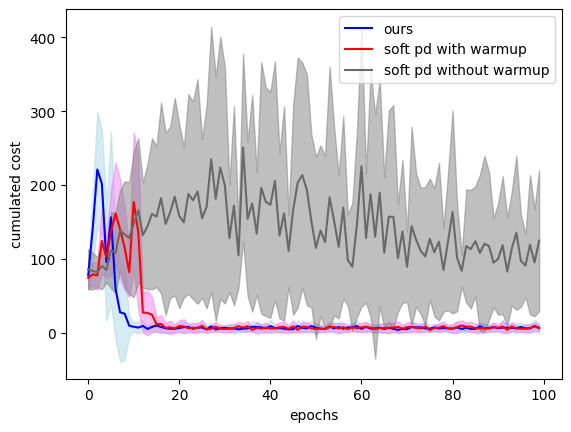

In [ ]:
plt.figure()

plt.plot(pd_cumulated_cost_during_learning_mean, color="blue", label="ours")
plt.fill_between(range(len(pd_cumulated_cost_during_learning_mean)), 
                 pd_cumulated_cost_during_learning_mean+pd_cumulated_cost_during_learning_std, 
                 pd_cumulated_cost_during_learning_mean-pd_cumulated_cost_during_learning_std, color="lightblue", alpha=0.5)

plt.plot(soft_pd_cumulated_cost_during_learning_mean, color="red", label="soft pd with warmup")
plt.fill_between(range(len(soft_pd_cumulated_cost_during_learning_mean)),
                soft_pd_cumulated_cost_during_learning_mean+soft_pd_cumulated_cost_during_learning_std, 
                soft_pd_cumulated_cost_during_learning_mean - soft_pd_cumulated_cost_during_learning_std,
                color="violet", alpha=0.5)

plt.plot(soft_pd_without_warmup_cumulated_cost_during_learning_mean, color="dimgray", label="soft pd without warmup")
plt.fill_between(range(len(soft_pd_cumulated_cost_during_learning_mean)),
                soft_pd_without_warmup_cumulated_cost_during_learning_mean + soft_pd_without_warmup_cumulated_cost_during_learning_std, 
                soft_pd_without_warmup_cumulated_cost_during_learning_mean - soft_pd_without_warmup_cumulated_cost_during_learning_std,
                color="gray", alpha=0.5)

plt.legend()
plt.xlabel("epochs")
plt.ylabel("cumulated cost")
plt.show()

Test policy

In [ ]:
from matplotlib.lines import Line2D
def test_learned_policy(x0, T=10):

    ts = np.arange(0, T, dt)
    xs_pd = [x0]
    xs_soft_pd = [x0]
    xs_soft_pd_without_warmup = [x0]
    xs_lqr = [x0]

    us_pd = []
    us_soft_pd = []
    us_soft_pd_without_warmup = []
    us_lqr = []

    cost_pd = 0
    cost_soft_pd = 0
    cost_soft_pd_without_warmup = 0
    cost_lqr = 0

    for t in ts:
        us_pd.append(np.array(get_pd_control(xs_pd[-1])))
        cost_pd += running_cost(xs_pd[-1], us_pd[-1]) * dt
        xs_pd.append(dynamics.simulate(xs_pd[-1], us_pd[-1]))

        us_soft_pd.append(np.array(get_soft_pd_control(xs_soft_pd[-1])))
        cost_soft_pd += running_cost(xs_soft_pd[-1], us_soft_pd[-1]) * dt
        xs_soft_pd.append(dynamics.simulate(xs_soft_pd[-1], us_soft_pd[-1]))

        us_soft_pd_without_warmup.append(np.array(get_soft_pd_without_warmup_control(xs_soft_pd_without_warmup[-1])))
        cost_soft_pd_without_warmup += running_cost(xs_soft_pd_without_warmup[-1], us_soft_pd_without_warmup[-1]) * dt
        xs_soft_pd_without_warmup.append(dynamics.simulate(xs_soft_pd_without_warmup[-1], us_soft_pd_without_warmup[-1]))

        us_lqr.append(get_lqr_control(xs_lqr[-1]))
        cost_lqr += running_cost(xs_lqr[-1], us_lqr[-1]) * dt
        xs_lqr.append(dynamics.simulate(xs_lqr[-1], us_lqr[-1]))
    
    # convert state to error cooridnates for better visualization
    for i in range(ts.shape[0]):
        xs_pd[i] = dynamics.states_wrap(xs_pd[i] - xf)
        xs_lqr[i] = dynamics.states_wrap(xs_lqr[i] - xf)
        xs_soft_pd[i] = dynamics.states_wrap(xs_soft_pd[i] - xf)
        xs_soft_pd_without_warmup[i] = dynamics.states_wrap(xs_soft_pd_without_warmup[i] - xf)

    xs_pd = np.array(xs_pd)
    xs_soft_pd = np.array(xs_soft_pd)
    xs_soft_pd_without_warmup = np.array(xs_soft_pd_without_warmup)
    xs_lqr = np.array(xs_lqr)

    return ts, xs_pd, xs_soft_pd, xs_soft_pd_without_warmup, xs_lqr, cost_pd, cost_soft_pd, cost_soft_pd_without_warmup, cost_lqr

def visualize_traj(ts, xs_pd, xs_soft_pd, xs_soft_pd_without_warmup, xs_lqr):

    fig, ax = plt.subplots()

    ax.plot(ts, xs_pd[:-1, 0], '-.', color = 'blue')
    ax.plot(ts, xs_pd[:-1, 1], '-', color = 'blue')
    ax.plot(ts, xs_pd[:-1, 2], '--', color='blue')
    ax.plot(ts, xs_pd[:-1, 3], ':' , color='blue')

    ax.plot(ts, xs_lqr[:-1, 0], '-.', color = 'green')
    ax.plot(ts, xs_lqr[:-1, 1], '-', color='green')
    ax.plot(ts, xs_lqr[:-1, 2], '--', color='green')
    ax.plot(ts, xs_lqr[:-1, 3], ':' , color='green')

    ax.plot(ts, xs_soft_pd[:-1, 0], '-.', color = 'red')
    ax.plot(ts, xs_soft_pd[:-1, 1], '-', color = 'red')
    ax.plot(ts, xs_soft_pd[:-1, 2], '--', color='red')
    ax.plot(ts, xs_soft_pd[:-1, 3], ':' , color='red')

    ax.set_ylim(ax.get_ylim())

    ax.plot(ts, xs_soft_pd_without_warmup[:-1, 0], '-.', color = 'grey')
    ax.plot(ts, xs_soft_pd_without_warmup[:-1, 1], '-', color = 'grey')
    ax.plot(ts, xs_soft_pd_without_warmup[:-1, 2], '--', color='grey')
    ax.plot(ts, xs_soft_pd_without_warmup[:-1, 3], ':' , color='grey')

    methods_legends_handle = [Line2D([0],[0], color='blue', label='ours'),
                            Line2D([0],[0], color='red', label="soft pd with warmup"),
                            Line2D([0],[0], color='grey', label="soft pd without warmup"),
                            Line2D([0],[0], color='green', label="lqr"),
                            ]
    
    methods_legends = ax.legend(handles=methods_legends_handle, loc="upper right")
    ax.add_artist(methods_legends)

    states_legends_handle = [Line2D([0],[0], color="blue", linestyle="dashdot", label="pos"),
                            Line2D([0],[0], color="blue", linestyle="solid", label="theta"),
                            Line2D([0],[0], color="blue", linestyle="dashed", label="vel"),
                            Line2D([0],[0], color="blue", linestyle="dotted", label="angular vel"),
                            ]
    ax.legend(handles=states_legends_handle, loc="lower right")
    
    ax.set_xlabel("time")
    ax.set_ylabel("states in error coordinates")

mean pd:  9.140910175230598
mean soft pd:  9.15915881211543
mean lqr:  9.140986134043468


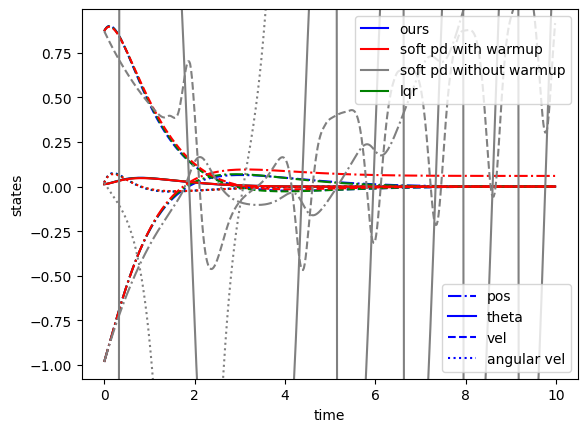

In [ ]:
x0 = dynamics.get_initial_state()
ts, xs_pd, xs_soft_pd, xs_soft_pd_without_warmup, xs_lqr, cost_pd, cost_soft_pd, cost_soft_pd_without_warmup, cost_lqr = test_learned_policy(x0)
cost_pd_list = [cost_pd]
cost_lqr_list = [cost_lqr]
cost_soft_pd_list = [cost_soft_pd]
cost_soft_pd_without_warmup_list = [cost_soft_pd_without_warmup]
visualize_traj(ts, xs_pd, xs_soft_pd, xs_soft_pd_without_warmup, xs_lqr)

for i in range(1, 10):
    x0 = dynamics.get_initial_state()
    ts, xs_pd, xs_soft_pd, xs_soft_pd_without_warmup, xs_lqr, cost_pd, cost_soft_pd, cost_soft_pd_without_warmup, cost_lqr = test_learned_policy(x0)
    cost_pd_list.append(cost_pd)
    cost_lqr_list.append(cost_lqr)
    cost_soft_pd_list.append(cost_soft_pd)
    cost_soft_pd_without_warmup_list.append(cost_soft_pd_without_warmup)

cost_pd_list = np.array(cost_pd_list)
cost_lqr_list = np.array(cost_lqr_list)
cost_soft_pd_list = np.array(cost_soft_pd_list)
print("mean pd: ", np.mean(cost_pd_list))
print("mean soft pd: ", np.mean(cost_soft_pd_list))
print("mean lqr: ", np.mean(cost_lqr_list))